In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets, models
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def mediapipeimg(image):

  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    results = hands.process(image)
    # print('Handedness:', results.multi_handedness)



    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    landmark_tangan=[]
    for hand_landmarks in results.multi_hand_landmarks:
     
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      fitur = []
      data = []
      for h in range(0,20):
          x = hand_world_landmarks.landmark[h].x
          y = hand_world_landmarks.landmark[h].y
          z = hand_world_landmarks.landmark[h].z
          fitur.append(x)
          fitur.append(y)
          fitur.append(z)
      data.extend(fitur)
      x = 0
      y = 0
      z = 0



    return results, annotated_image, data

In [10]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='../gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr



In [11]:
import torch.nn.functional as F


class MyModelDefault(nn.Module):
    def __init__(self):
        super(MyModelDefault, self).__init__()
        self.cnn = timm.create_model('resnet10t.c3_in1k', pretrained=True)
        self.cnn.fc = nn.Linear(
            self.cnn.fc.in_features, 300
        )
        self.fc1 = nn.Linear(self.cnn.fc.out_features + 63, 100)
        self.fc2 = nn.Linear(100, 36)
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        x = torch.cat((x1, x2), dim=1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
modelku = torch.load("resnet+feature.pth")
modelku.cuda()
modelku.eval()

MyModelDefault(
  (cnn): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [13]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        if self.featureExtraction:
            feature, err = self.featureExtraction(image)
            if (err != None):
                return self.__getitem__(idx + 1)
            else:
                custom_features = feature
        
        
        hasil = {
            'image': image,
            'labels': label,
            'id_class': idx,
            'custom_features': custom_features,
            'data': data
        }
        
        return hasil

In [14]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../asl_dataset", transform=train_transform, featureExtraction=handGesture)

print(type(dataset))

<class '__main__.dawtaset'>


In [15]:
a = dataset.__getitem__(0)
a

{'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'labels': 0,
 'id_class': 0,
 'custom_features': [0.21939972043037415,
  0.5602226853370667,
  8.590669722252642e-07,
  0.25217491388320923,
  0.5305596590042114,
  -0.065203383564

C:\Users\intel\AppData\Local\Temp\ipykernel_11184\2945756074.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2318.)
  ax[0,i].imshow(hasil["image"].T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)


Text(0, 0.5, 'Augmented Images')

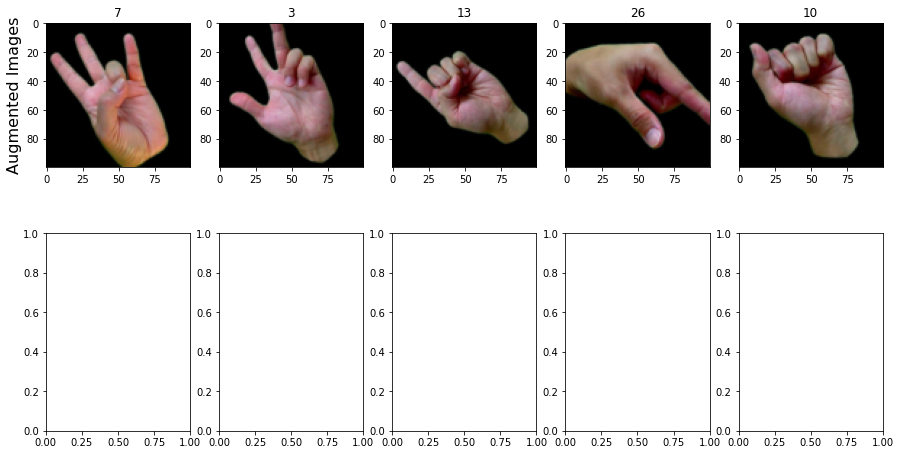

In [16]:
#Visualizing some examples in the training dataset X
from random import randrange


def detects(img):
    imageT = train_transform(img)
    imageT = imageT.unsqueeze(0)
    # print(f"Image shape after: {image.shape}")
    imageT = imageT.to(device)
    datafitur, err = handGesture(img)
    datafitur = torch.as_tensor(datafitur).unsqueeze(0)
    datafitur = datafitur.to(device)


fig, ax = plt.subplots(nrows = 2, ncols = 5,  figsize = (15,8))
for i in range(5):
    a = randrange(2000)
    hasil = dataset.__getitem__(a)
    
    ax[0,i].imshow(hasil["image"].T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
    ax[0,i].set_title(int(hasil["labels"]))
    

ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})